# Synthetic Gaussian-Bump  Manifold: Comparison of Gaussian smoothing and Manifold-Adapted Smoothing
- In this notebook, we construct a 1d manifold of 'Gaussian bump' images, and compare Gaussian smoothing and manifold-adapted smoothing generations
- Run smoothed diffusion models using both types of smoothing
    - isotropic Gaussian smoothing
    - manifold-adapted smoothing - smoothing along a translated version of the manifold, passing through the current point
- Report the following:
    - $L_2$ distance to manifold, relative to the $L_2$ distance to the empirical samples (implicitly controlled by changing the smoothing parameter)
    - 'Anisotropy' of the generated samples (considered as pdfs), relative to the $L_2$ distance to the empirical sample (implicitly controlled by changing the smoothing parameter)
    - Histograms showing the spread of the generated samples along the manifold, for different smoothing levels

In [ ]:
import os  # before importing anything jax
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import jax
# jax.config.update('jax_platform_name', 'cpu')
os.environ['CUDA_VISIBLE_DEVICES']='0'

import jax.numpy as jnp
from jax.scipy.special import logsumexp

import matplotlib.pyplot as plt

from src.diffusion import VE_diffuser, log_hat_pt, empirical_eps_fn, sample_rev
from src.plotting import plot_images, add_arrows
from src.smoothing import get_smoothed_fn, get_proj_idx_interpolant, get_manifold_translated_smoothed_fn

import seaborn as sns
from matplotlib.lines import Line2D
sns.set_theme()  # sets a nicer global style for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})

## construct the synthetic manifold
- We consider a synthetic 1d image manifold defined by a closed curve $\phi : [0, 2\pi) \to \R^{\text{64} \times \text{64}}$
- The curve maps each angle to an image of a bump function centred at the corresponding angle $\alpha$ around a circle

In [11]:
def get_Gaussian_imagefn(image_size=128, radius=1.0, std=0.1):
    def image_fn(theta):
        # Center of Gaussian on the circle of radius 'radius' in [-1,1]^2
        cx = radius * jnp.cos(theta)
        cy = radius * jnp.sin(theta)

        # Create grid from -1 to 1 (independent of radius)
        x = jnp.linspace(-1, 1, image_size)
        y = jnp.linspace(-1, 1, image_size)
        xv, yv = jnp.meshgrid(x, y)

        # Compute Gaussian density
        gauss = jnp.exp(-((xv - cx)**2 + (yv - cy)**2) / (2 * std**2))

        # Normalize to max 1
        gauss /= gauss.max()

        # return gauss
        return flatten_image(gauss).reshape((image_size, image_size, 1))

    return image_fn

def flatten_image(image):
    return image.ravel()

def unflatten_image(flat_image):
    size = int(jnp.sqrt(flat_image.size))
    return flat_image.reshape((size, size))


# make plot showing traversal of the manifold
from fractions import Fraction

def format_theta_label(theta):
    theta_float = float(theta.item())
    frac = Fraction(theta_float / jnp.pi).limit_denominator()
    n, d = frac.numerator, frac.denominator

    if n == 0:
        return r"$\theta = 0$"
    elif n == d:
        return r"$\theta = \pi$"
    elif n == -d:
        return r"$\theta = -\pi$"
    elif d == 1:
        return rf"$\theta = {n}\pi$"
    elif n == 1:
        return rf"$\theta = \frac{{\pi}}{{{d}}}$"
    elif n == -1:
        return rf"$\theta = -\frac{{\pi}}{{{d}}}$"
    else:
        return rf"$\theta = \frac{{{n}\pi}}{{{d}}}$"

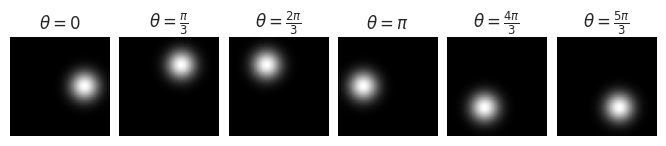

In [12]:
size = 64
radius = 0.5
std = 0.2

pixel_curve = get_Gaussian_imagefn(size, radius, std)

num_data_points = 6
thetas = jnp.linspace(0, 2*jnp.pi, num_data_points, endpoint=False)
manifold_images = jax.vmap(pixel_curve)(thetas)

# Plot manifold images in a row
fig, axes = plt.subplots(1, num_data_points, figsize=(7, 4))
for i, ax in enumerate(axes):
    ax.imshow(unflatten_image(manifold_images[i]), cmap='gray', origin='lower', extent=(-1,1,-1,1))
    ax.axis('off')
    ax.set_title(format_theta_label(thetas[i]), fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
# plt.savefig('figures/gaussian_bump_manifold.pdf', bbox_inches='tight')
plt.show()

## generate points
- We will generate a small number of points along the curve to use as the empirical training dataset
- We also generate a large number of points to use as an approximation to the true manifold

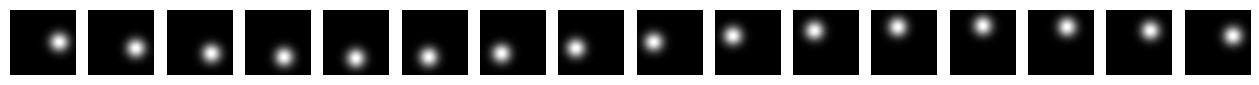

In [13]:
# define the 'ground truth' manifold, using many points
all_alphas = jnp.linspace(0, 2*jnp.pi, 1024, endpoint=False)  # 1024 points for smooth curve
interpolants = jnp.array([pixel_curve(alpha) for alpha in all_alphas])  # approx to the true manifold

# define the training dataset
num_points = 16  # Number of empirical datapoints for diffusion
train_alphas = jnp.linspace(0, 2*jnp.pi, num_points, endpoint=False)
train_images = jnp.array([pixel_curve(alpha) for alpha in train_alphas])

image_shape = train_images.shape[1:]

plot_images(train_images, n=num_points)  # visualise the training images

In [14]:
# function to return the closest image
def get_closest_image(image, images):
    """Find the closest image in the dataset to the given image."""
    diffs = jnp.sqrt( jnp.sum((images - image) ** 2, axis=(1, 2, 3)) ) # norm differences
    closest_idx = jnp.argmin(diffs)
    return images[closest_idx], diffs[closest_idx], closest_idx

## Diffusion
- Now, we will run a VE diffusion model using the various different score functions

In [15]:
# first, define the VE diffusion object
ve = VE_diffuser(sigma_min=0.001, sigma_max=3.0)

In [16]:
# helper function for computing anisotropies for generated samplers, as a measure of the 'roundness' of the generated bumps (which corresponds to visually being 'on-manifold')
threshold = 1e-1

def compute_image_covariance_jax(image):
    """
    input: (64,64) array
    returns: covariance matrix, as it input are values of a Gaussian pdf
    """

    # clip values close to 0.0
    image_clipped = jnp.where(image < threshold, 0.0, image)

    # normalize
    total = jnp.sum(image_clipped)
    if total == 0:
        raise ValueError("Image has zero total intensity after clipping.")
    p = image_clipped / total

    # create coordinate grids
    H, W = image.shape
    y_coords, x_coords = jnp.meshgrid(jnp.arange(H), jnp.arange(W), indexing='ij')

    # compute mean
    mu_x = jnp.sum(x_coords * p)
    mu_y = jnp.sum(y_coords * p)

    # center coordinates
    dx = x_coords - mu_x
    dy = y_coords - mu_y

    # compute covariance components
    cov_xx = jnp.sum(p * dx * dx)
    cov_xy = jnp.sum(p * dx * dy)
    cov_yy = jnp.sum(p * dy * dy)

    cov_matrix = jnp.array([
        [cov_xx, cov_xy],
        [cov_xy, cov_yy]
    ])

    return cov_matrix

def get_anisotropy_of_sample(sample):
    # reshaped_image = unflatten_image(sample)
    sample = jnp.squeeze(sample, axis=-1)
    cov_matrix = compute_image_covariance_jax(sample)
    eigvals = jnp.linalg.eigvalsh(cov_matrix)
    anisotropy = eigvals.max() / eigvals.min()  # = 1 means perfectly round
    return anisotropy

def get_anisotropies_of_batch(batch):
    anisotropies = []
    for image in batch:
        anisotropy = get_anisotropy_of_sample(image)
        anisotropies.append(anisotropy)
    return jnp.array(anisotropies)

### Empirical score generations
- We first run the diffusion process using the empirical score function
- This should generate only training samples

Empirical Score Generations:


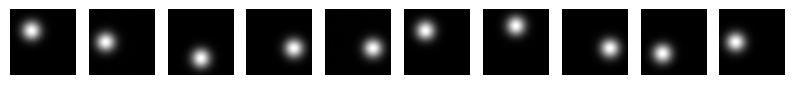

---------------------
Closest images in dataset:


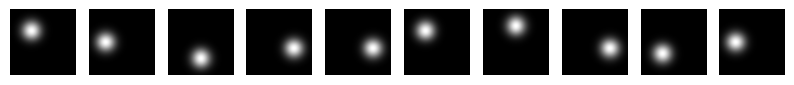

Distance to nearest training datapoint: [0.0651211  0.06377085 0.06438528 0.06433335 0.06231634 0.06308299
 0.06302384 0.0640641  0.06344839 0.06528433]
---------------------
Closest images on manifold:


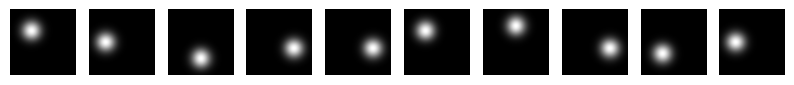

Distance to nearest point on manifold: [0.0651211  0.06377085 0.06438528 0.06433335 0.06231634 0.06308299
 0.06302384 0.0640641  0.06344839 0.06528433]
---------------------
Anisotropies:
[1.000271  1.0143864 1.0104905 1.0099987 1.0098479 1.0040911 1.0094357
 1.0070667 1.0021881 1.0113187]


In [17]:
num_samples = 10

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

key = jax.random.PRNGKey(0)
xs, traj = sample_rev(ve, key, data_empirical_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

print('Empirical Score Generations:')
plot_images(xs, n=num_samples)

print('---------------------')
print('Closest images in dataset:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(xs, train_images)
plot_images(closest_images, n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------')
print('Closest images on manifold:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(xs, interpolants)
plot_images(closest_images, n=num_samples)
print('Distance to nearest point on manifold:', dists)

print('---------------------')
print('Anisotropies:')
anisotropies = get_anisotropies_of_batch(xs)
print(anisotropies)

### Smoothed diffusion with an isotropic Gaussian kernel

Generations:


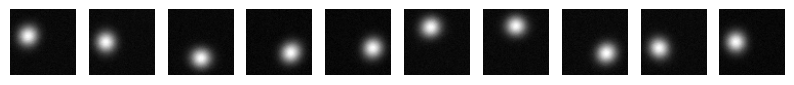

---------------------
Closest images in dataset:


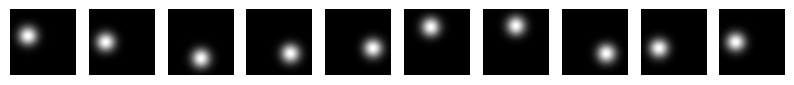

Distance to nearest training datapoint: [1.0229347 1.0034943 1.0403684 1.6365768 1.0097306 1.0489894 1.0271575
 1.1125765 1.0276264 1.0220461]
---------------------
Closest images on manifold:


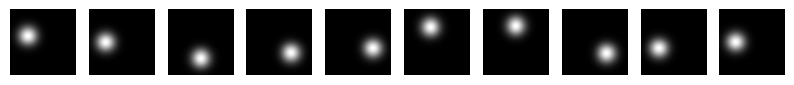

Distance to nearest point on manifold: [1.0229347 1.0019387 1.0400517 1.2110025 1.0097306 1.0230391 1.0254617
 1.0576429 1.0276264 1.0160484]
---------------------
Anisotropies:
[1.1409266 1.1357228 1.1362056 1.2089791 1.1549889 1.1421287 1.1262816
 1.1398354 1.158785  1.143388 ]


In [18]:
# run smoothed diffusion
num_samples = 10

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

smoothing_param = 2.4
smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=50_000)

key = jax.random.PRNGKey(0)
gaussian_samples, traj = sample_rev(ve, key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

print('Generations:')
plot_images(gaussian_samples, n=num_samples)

print('---------------------')
print('Closest images in dataset:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(gaussian_samples, train_images)
plot_images(closest_images, n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------')
print('Closest images on manifold:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(gaussian_samples, interpolants)
plot_images(closest_images, n=num_samples)
print('Distance to nearest point on manifold:', dists)

print('---------------------')
print('Anisotropies:')
anisotropies = get_anisotropies_of_batch(gaussian_samples)
print(anisotropies)

### Smoothed diffusion with manifold-adapted kernel
- Here, we use a manifold-adapted smoothing kernel that smooths the empirical score along a translation of the manifold through the current position

Generations:


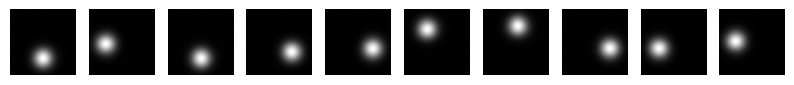

---------------------
Closest images in dataset:


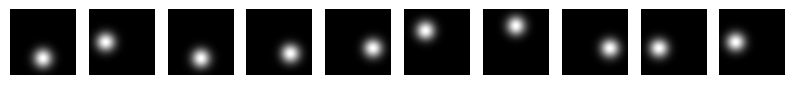

Distance to nearest training datapoint: [0.23753552 2.2445204  0.36429435 2.6123245  0.53229326 2.7855477
 2.3791354  0.21385765 0.2840362  1.1554204 ]
---------------------
Closest images on manifold:


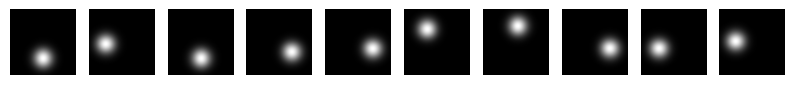

Distance to nearest point on manifold: [0.1461762  0.11972204 0.10431644 0.10563526 0.28605518 0.21334434
 0.19076388 0.20385133 0.1979419  0.15866049]
---------------------
Anisotropies:
[1.0155381 1.0105239 1.0124387 1.0103096 1.0428507 1.031674  1.029106
 1.0230321 1.023496  1.0185837]


In [19]:
num_samples = 10

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

smoothed_emp_eps_fn = get_manifold_translated_smoothed_fn(data_empirical_eps_fn, 7.0, all_alphas, interpolants, n=1000)

key = jax.random.PRNGKey(0)
adapted_samples, traj = sample_rev(ve, key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

print('Generations:')
plot_images(adapted_samples, n=num_samples)

print('---------------------')
print('Closest images in dataset:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(adapted_samples, train_images)
plot_images(closest_images, n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------')
print('Closest images on manifold:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(adapted_samples, interpolants)
plot_images(closest_images, n=num_samples)
print('Distance to nearest point on manifold:', dists)

print('---------------------')
print('Anisotropies:')
anisotropies = get_anisotropies_of_batch(adapted_samples)
print(anisotropies)

## generate many samples, to use for generating the plots
- We now compare the different mechanisms, for increasing smoothing levels
- The smoothing levels are selected to induce comparable $L_2$ distances from the empirical dataset in the samples

### Gaussian smoothing

In [20]:
def run_gaussian_smoothing_param(smoothing_param,
                         num_samples=100,
                         batch_size=20,
                         num_steps=100,
                         n_smooth=50_000,
                         key=jax.random.PRNGKey(0)):

    num_batches = num_samples // batch_size

    # Define smoothed empirical eps function
    data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=n_smooth)

    gaussian_samples = []
    dists_to_data = []
    dists_to_manifold = []
    proj_alphas = []

    for _ in range(num_batches):
        key, subkey = jax.random.split(key)
        gaussian_samples_batch, _ = sample_rev(
            ve, subkey, smoothed_emp_eps_fn, batch_size,
            image_shape=image_shape, num_steps=num_steps
        )

        gaussian_samples.append(gaussian_samples_batch)

        # Distance to data
        _, dists_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
            gaussian_samples_batch, train_images)
        dists_to_data.append(dists_data)

        # Distance to manifold
        _, dists_manifold, closest_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(
            gaussian_samples_batch, interpolants)
        dists_to_manifold.append(dists_manifold)

        proj_alphas.append(all_alphas[closest_idxs])

    gaussian_samples = jnp.concatenate(gaussian_samples, axis=0)
    dists_to_data = jnp.concatenate(dists_to_data, axis=0)
    dists_to_manifold = jnp.concatenate(dists_to_manifold, axis=0)
    proj_alphas = jnp.concatenate(proj_alphas, axis=0)

    anisotropies = get_anisotropies_of_batch(gaussian_samples)

    return gaussian_samples, dists_to_data, dists_to_manifold, anisotropies, proj_alphas

In [21]:
num_samples = 100
batch_size = 10
num_steps = 100
n_smooth = 50_000 # reduced for memory reasons, the plots were made with 50_000. More samples means better approximation of the smoothed score function

gaussian_smoothing_params =  jnp.array([1.0, 1.4, 1.8, 2.0, 2.2, 2.4, 2.6])

all_gaussian_samples = []
all_gaussian_dists_to_data = []
all_gaussian_dists_to_manifold = []
all_gaussian_proj_alphas = []
all_gaussian_anisotropies = []

for smoothing_param in gaussian_smoothing_params:
    print(f'Running smoothing param: {smoothing_param}')
    samples, dists_to_data, dists_to_manifold, anisotropies, proj_alphas = run_gaussian_smoothing_param(
        smoothing_param, num_samples=num_samples, batch_size=batch_size, num_steps=num_steps, n_smooth=n_smooth)

    all_gaussian_samples.append(samples)
    all_gaussian_dists_to_data.append(dists_to_data)
    all_gaussian_dists_to_manifold.append(dists_to_manifold)
    all_gaussian_anisotropies.append(anisotropies)
    all_gaussian_proj_alphas.append(proj_alphas)

all_gaussian_samples = jnp.array(all_gaussian_samples)
all_gaussian_dists_to_data = jnp.array(all_gaussian_dists_to_data)
all_gaussian_dists_to_manifold = jnp.array(all_gaussian_dists_to_manifold)
all_gaussian_anisotropies = jnp.array(all_gaussian_anisotropies)
all_gaussian_proj_alphas = jnp.array(all_gaussian_proj_alphas)

Running smoothing param: 1.0
Running smoothing param: 1.399999976158142
Running smoothing param: 1.7999999523162842
Running smoothing param: 2.0
Running smoothing param: 2.200000047683716
Running smoothing param: 2.4000000953674316
Running smoothing param: 2.5999999046325684


We can examine to what extent the generated samples are spread along the manifold by plotting histograms of the $\alpha$ parameter of the projection onto the manifold. For small smoothing level $\sigma$, they should be concentrated on the empirical datapoint locations, while for larger $\sigma$ we want to see to what extent they have spread out to fill the gaps.

smoothing sigma:  1.4


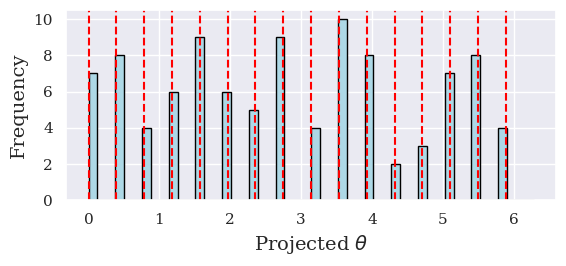

smoothing sigma:  2.2


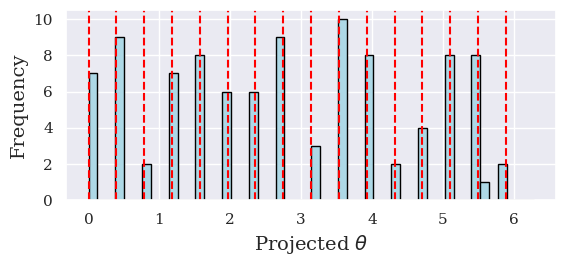

smoothing sigma:  2.6


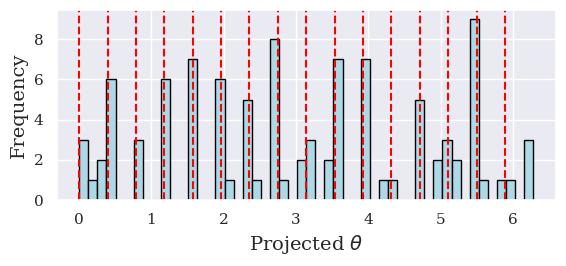

In [22]:
def plot_histogram(proj_alphas, savedir=None):
    plt.figure(figsize=(6,3))
    plt.hist(proj_alphas, bins=50, range=(0, 2*jnp.pi), color='lightblue', edgecolor='black')

    # Overlay vertical lines for true theta values
    for theta in train_alphas:
        plt.axvline(theta, color='red', linestyle='--', linewidth=1.5)

    # Axis labels and formatting
    plt.xlabel('Projected $\\theta$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()

    if savedir is not None:
        plt.savefig(savedir, bbox_inches='tight') #, dpi = 1000)
    plt.show()

plot_histogram_idxs = [1,4,6]

for idx in plot_histogram_idxs:
    smoothing_param = gaussian_smoothing_params[idx]
    print('smoothing sigma: ', smoothing_param)
    smoothing_param_str = f"{smoothing_param:.1f}".replace('.', '_')
    plot_histogram(all_gaussian_proj_alphas[idx]) #, savedir=f'figures/histogram_gaussian_smoothing_{smoothing_param_str}.pdf')

### manifold-adapted smoothing

In [23]:
def run_adapted_smoothing_param(smoothing_param,
                         num_samples=100,
                         batch_size=20,
                         num_steps=100,
                         n_smooth=1_000,
                         key=jax.random.PRNGKey(0)):

    data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

    num_batches = num_samples // batch_size

    # Define smoothed empirical eps function
    smoothed_emp_eps_fn = get_manifold_translated_smoothed_fn(data_empirical_eps_fn, smoothing_param, all_alphas, interpolants, n=n_smooth)

    adapted_samples = []
    dists_to_data = []
    dists_to_manifold = []
    proj_alphas = []

    for _ in range(num_batches):
        key, subkey = jax.random.split(key)
        adapted_samples_batch, _ = sample_rev(
            ve, subkey, smoothed_emp_eps_fn, batch_size,
            image_shape=image_shape, num_steps=num_steps
        )

        adapted_samples.append(adapted_samples_batch)

        # Distance to data
        _, dists_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
            adapted_samples_batch, train_images)
        dists_to_data.append(dists_data)

        # Distance to manifold
        _, dists_manifold, closest_idx = jax.vmap(get_closest_image, in_axes=(0, None))(
            adapted_samples_batch, interpolants)
        dists_to_manifold.append(dists_manifold)

        proj_alphas.append(all_alphas[closest_idx])

    adapted_samples = jnp.concatenate(adapted_samples, axis=0)
    dists_to_data = jnp.concatenate(dists_to_data, axis=0)
    dists_to_manifold = jnp.concatenate(dists_to_manifold, axis=0)
    proj_alphas = jnp.concatenate(proj_alphas, axis=0)

    anisotropies = get_anisotropies_of_batch(adapted_samples)

    return adapted_samples, dists_to_data, dists_to_manifold, anisotropies, proj_alphas

In [24]:
n_smooth = 1_000

adapted_smoothing_params = jnp.array([1.6, 2.4, 3.2, 3.5, 3.8, 4.4, 5.0])

all_adapted_samples = []
all_adapted_dists_to_data = []
all_adapted_dists_to_manifold = []
all_adapted_proj_alphas = []
all_adapted_anisotropies = []

for smoothing_param in adapted_smoothing_params:
    print(f'Running smoothing param: {smoothing_param}')
    samples, dists_to_data, dists_to_manifold, anisotropies, proj_alphas = run_adapted_smoothing_param(
        smoothing_param, num_samples=num_samples, batch_size=batch_size, num_steps=num_steps, n_smooth=n_smooth)

    all_adapted_samples.append(samples)
    all_adapted_dists_to_data.append(dists_to_data)
    all_adapted_dists_to_manifold.append(dists_to_manifold)
    all_adapted_anisotropies.append(anisotropies)
    all_adapted_proj_alphas.append(proj_alphas)

all_adapted_samples = jnp.array(all_adapted_samples)
all_adapted_dists_to_data = jnp.array(all_adapted_dists_to_data)
all_adapted_dists_to_manifold = jnp.array(all_adapted_dists_to_manifold)
all_adapted_anisotropies = jnp.array(all_adapted_anisotropies)
all_adapted_proj_alphas = jnp.array(all_adapted_proj_alphas)

Running smoothing param: 1.600000023841858
Running smoothing param: 2.4000000953674316
Running smoothing param: 3.200000047683716
Running smoothing param: 3.5
Running smoothing param: 3.799999952316284
Running smoothing param: 4.400000095367432
Running smoothing param: 5.0


smoothing sigma:  2.4


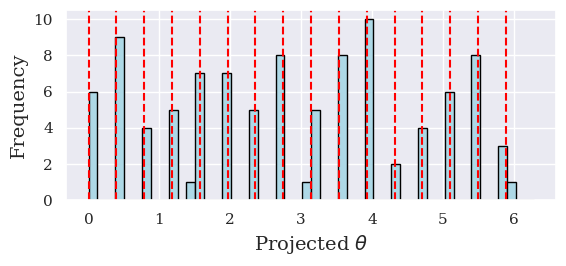

smoothing sigma:  3.8


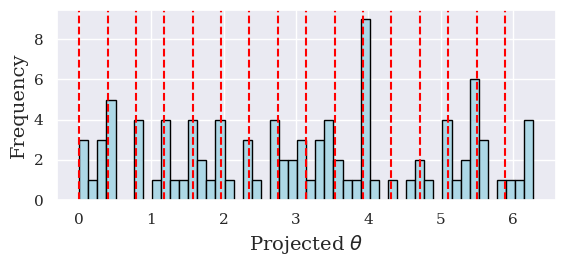

smoothing sigma:  5.0


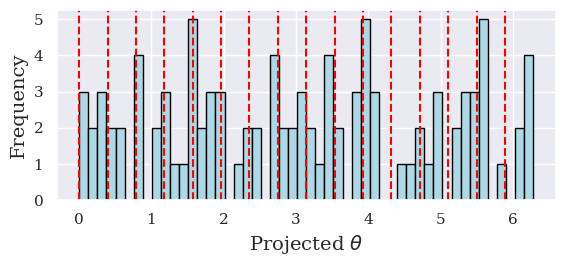

In [25]:
plot_histogram_idxs = [1,4,6]

for idx in plot_histogram_idxs:
    smoothing_param = adapted_smoothing_params[idx]
    print('smoothing sigma: ', smoothing_param)
    smoothing_param_str = f"{smoothing_param:.1f}".replace('.', '_')
    plot_histogram(all_adapted_proj_alphas[idx]) #, savedir=f'figures/histogram_adapted_smoothing_{smoothing_param_str}.pdf')

## Visualise some of the generated samples

Samples from Gaussian-smoothed diffusion model:


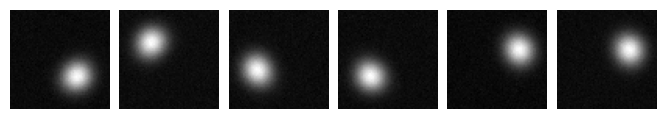

Samples from Manifold-adapted smoothing diffusion model:


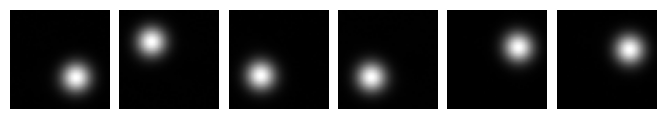

In [26]:
# Plot gaussian images in a row
plot_samples = all_gaussian_samples[-1]

num_plotted_samples = 6
fig, axes = plt.subplots(1, num_plotted_samples, figsize=(7, 4))
for i, ax in enumerate(axes):
    ax.imshow(unflatten_image(plot_samples[i]), cmap='gray', origin='lower', extent=(-1,1,-1,1))
    ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
print('Samples from Gaussian-smoothed diffusion model:')
# plt.savefig('figures/bump_gaussian_samples.pdf', bbox_inches='tight')
plt.show()

# Plot manifold images in a row
plot_samples = all_adapted_samples[-1]

num_plotted_samples = 6
fig, axes = plt.subplots(1, num_plotted_samples, figsize=(7, 4))
for i, ax in enumerate(axes):
    ax.imshow(unflatten_image(plot_samples[i]), cmap='gray', origin='lower', extent=(-1,1,-1,1))
    ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
print('Samples from Manifold-adapted smoothing diffusion model:')
# plt.savefig('figures/bump_adapted_samples.pdf', bbox_inches='tight')
plt.show()

Visibly, we can see a slight difference in the generated samples. Those generated using the manifold-adapted smoothing appear more 'round', which corresponds visually to being 'on-manifold'. We measure this quantitatively in the anisotropy plot below.

## also compare to KDE samples

In [27]:
KDE_params = jnp.array([0.003, 0.006, 0.009, 0.012, 0.015, 0.018 , 0.021, 0.024])

all_KDE_samples = []
all_KDE_dists_to_data = []
all_KDE_dists_to_manifold = []

key = jax.random.PRNGKey(0)
for KDE_param in KDE_params:

    key, mean_subkey, noise_subkey = jax.random.split(key, 3)
    mean_idxs = jax.random.choice(mean_subkey, num_points, shape=(num_samples,), replace=True)
    samples = train_images[mean_idxs] + KDE_param * jax.random.normal(noise_subkey, shape=(num_samples, *image_shape))

    # Distance to data
    _, dists_to_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
        samples, train_images)

    # Distance to manifold
    _, dists_to_manifold, closest_idx = jax.vmap(get_closest_image, in_axes=(0, None))(
        samples, interpolants)

    all_KDE_samples.append(samples)
    all_KDE_dists_to_data.append(dists_to_data)
    all_KDE_dists_to_manifold.append(dists_to_manifold)

all_KDE_samples = jnp.array(all_KDE_samples)
all_KDE_dists_to_data = jnp.array(all_KDE_dists_to_data)
all_KDE_dists_to_manifold = jnp.array(all_KDE_dists_to_manifold)

## make the plots

First, plot how the $L_2$ distance to the training data changes with the $L_2$ distance to the manifold, as the amount of smoothing increases

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1980310735.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Distance to $\mathcal{M}$")


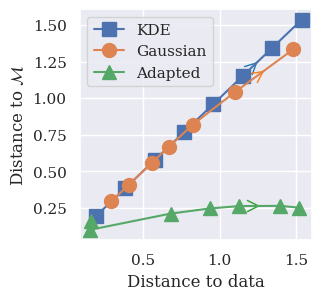

In [28]:
avg_gaussian_data_distances = jnp.mean(all_gaussian_dists_to_data, axis=1)
avg_gaussian_manifold_distances = jnp.mean(all_gaussian_dists_to_manifold, axis=1)

avg_adapted_data_distances = jnp.mean(all_adapted_dists_to_data, axis=1)
avg_adapted_manifold_distances = jnp.mean(all_adapted_dists_to_manifold, axis=1)

avg_KDE_data_distances = jnp.mean(all_KDE_dists_to_data, axis=1)
avg_KDE_manifold_distances = jnp.mean(all_KDE_dists_to_manifold, axis=1)

# Plot scatter plot with arrows
plt.figure(figsize=(3,3))

# Plot and extract line objects
line_KDE = plt.plot(avg_KDE_data_distances, avg_KDE_manifold_distances,  marker='s', ms=10, label='KDE')[0]
line_gaussian = plt.plot(avg_gaussian_data_distances, avg_gaussian_manifold_distances,  marker='o', ms=10, label='Gaussian')[0]
line_adapted = plt.plot(avg_adapted_data_distances, avg_adapted_manifold_distances,  marker='^', ms=10, label='Adapted')[0]

# Add arrows to the lines
add_arrows(line_KDE, segment_index=5, color='tab:blue')
add_arrows(line_gaussian, segment_index=5, color='tab:orange')
add_arrows(line_adapted, segment_index=4, color='tab:green')

plt.xlabel("Distance to data")
plt.ylabel("Distance to $\mathcal{M}$")
plt.grid(True)

# Add y = x reference line
min_val = min(
    avg_adapted_manifold_distances.min(),
    avg_adapted_data_distances.min(),
    avg_gaussian_manifold_distances.min(),
    avg_gaussian_data_distances.min()
)
max_val = max(
    avg_adapted_manifold_distances.max(),
    avg_adapted_data_distances.max(),
    avg_gaussian_manifold_distances.max(),
    avg_gaussian_data_distances.max()
)
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')
plt.legend(loc='upper left')

# plt.savefig("gaussian_bump_L2s.pdf", bbox_inches='tight', dpi = 1000)
plt.show()

Now plot how the 'anisotropy' of the generated samples changes with the distance from the training data (implicitly controlled by increasing the smoothing)

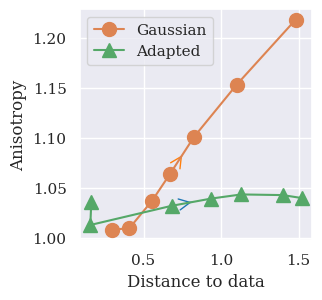

In [29]:
# Plot scatter plot with arrows
plt.figure(figsize=(3,3))

average_adapted_anisotropies = jnp.mean(all_adapted_anisotropies, axis=1)
average_gaussian_anisotropies = jnp.mean(all_gaussian_anisotropies, axis=1)


pal = sns.color_palette()
orange, green = pal[1], pal[2]

# Plot and extract line objects
line_gaussian = plt.plot(avg_gaussian_data_distances, average_gaussian_anisotropies,  marker='o', ms=10, label='Gaussian', color=orange)[0]
line_adapted = plt.plot(avg_adapted_data_distances, average_adapted_anisotropies,  marker='^', ms=10, label='Adapted', color=green)[0]

# Add arrows to the lines
add_arrows(line_adapted, segment_index=2, color='tab:blue')
add_arrows(line_gaussian, segment_index=3, color='tab:orange')

plt.xlabel("Distance to data")
plt.ylabel("Anisotropy")
plt.grid(True)

# plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')
plt.legend(loc='upper left')

# plt.savefig("gaussian_bump_anisotropy.pdf", bbox_inches='tight', dpi = 1000)
plt.show()

# Bump-function width scale comparison
- Finally, we consider changing the width of the bump function, to see in what way this influences the effects observed above
- We use the manifold-adapted smoothing and compare different bump function widths. It appears that decreasing the width of the bump function makes it harder for the manifold-adapted smoothing to generate samples close to the manifold structure

In [45]:
# values of eta to change the manifold structure
eta_values = [0.25, 0.2, 0.15]

smoothing_params = 0.5 * jnp.array([3.2, 3.5, 3.8, 4.4, 5.0])

num_configs = len(smoothing_params)

num_points = 24 # 20, 28  # Number of empirical datapoints for diffusion (use slightly more, because using lower eta values)

# params for generation
num_samples = 100
batch_size = 100
num_steps = 100
n_smooth = 1_000

size = 64
radius = 0.5

# Storage for results
all_etas_manifold_distances = []
all_etas_data_distances = []

key = jax.random.PRNGKey(0)

for eta in eta_values:
    print(f"Running for eta = {eta}")

    # define pixel curve with given curvature
    pixel_curve = get_Gaussian_imagefn(size, radius, eta)

    # get the training points
    train_alphas = jnp.linspace(0, 2*jnp.pi, num_points, endpoint=False)
    train_images = jnp.array([pixel_curve(alpha) for alpha in train_alphas])

    manifold_distances = []
    data_distances = []

    # make ground-truth manifold
    all_eta_alphas = jnp.linspace(0, 2*jnp.pi, 1024, endpoint=False)
    eta_interpolants = jnp.array([pixel_curve(alpha) for alpha in all_eta_alphas])

    for i, smoothing_param in enumerate(smoothing_params):
        print(f'run {i}, parameter {smoothing_param}')

        data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

        # Define smoothed empirical eps function
        smoothed_emp_eps_fn = get_manifold_translated_smoothed_fn(data_empirical_eps_fn, smoothing_param, all_eta_alphas, eta_interpolants, n=n_smooth)

        samples, _ = sample_rev(
            ve, key, smoothed_emp_eps_fn, num_samples,
            image_shape=image_shape, num_steps=num_steps
        )

        # Distance to data
        _, dists_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
            samples, train_images)
        data_distances.append(dists_data)

        # Distance to manifold
        _, dists_manifold, closest_idx = jax.vmap(get_closest_image, in_axes=(0, None))(
            samples, eta_interpolants)
        manifold_distances.append(dists_manifold)

    all_etas_manifold_distances.append(manifold_distances)
    all_etas_data_distances.append(data_distances)

all_etas_manifold_distances = jnp.array(all_etas_manifold_distances)
all_etas_data_distances = jnp.array(all_etas_data_distances)


Running for eta = 0.25
run 0, parameter 1.600000023841858
run 1, parameter 1.75
run 2, parameter 1.899999976158142
run 3, parameter 2.200000047683716
run 4, parameter 2.5
Running for eta = 0.2
run 0, parameter 1.600000023841858
run 1, parameter 1.75
run 2, parameter 1.899999976158142
run 3, parameter 2.200000047683716
run 4, parameter 2.5
Running for eta = 0.15
run 0, parameter 1.600000023841858
run 1, parameter 1.75
run 2, parameter 1.899999976158142
run 3, parameter 2.200000047683716
run 4, parameter 2.5


<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-4222104499.py:19: SyntaxWarning: invalid escape sequence '\e'
  label=f'$\eta={curvature}$')[0]
/tmp/ipython-input-4222104499.py:26: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Distance to $\mathcal{M}$")


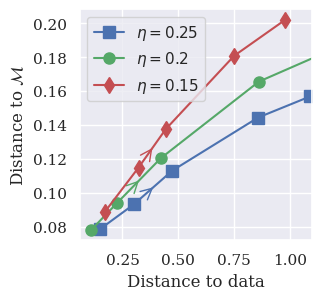

In [46]:
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'font.family': 'serif'})

plt.figure(figsize=(3,3))
colors = ['b', 'g', 'r', 'purple']
markers = ['s', 'o', 'd', 'x']

average_etas_manifold_distances = jnp.mean(all_etas_manifold_distances, axis=2)
average_etas_data_distances = jnp.mean(all_etas_data_distances, axis=2)

# Plot each curve and add arrows
for i, curvature in enumerate(eta_values):
    line = plt.plot(average_etas_data_distances[i],
                   average_etas_manifold_distances[i],
                   marker=markers[i],
                   ms=8,
                   linestyle='-',
                   color=colors[i],
                   label=f'$\eta={curvature}$')[0]

    # Add arrow to specific segment based on curvature index
    segment_to_arrow = [1, 1, 1, 0][i]  # 2nd, 2nd, 2nd, 1st segments respectively
    add_arrows(line, segment_to_arrow, color=colors[i])

plt.xlabel("Distance to data")
plt.ylabel("Distance to $\mathcal{M}$")
plt.grid(True)

# Compute overall min/max values correctly
all_manifold_distances = jnp.concatenate(average_etas_manifold_distances)
all_data_distances = jnp.concatenate(average_etas_data_distances)

min_val = jnp.min(jnp.concatenate([all_manifold_distances, all_data_distances]))
max_val = jnp.max(jnp.concatenate([all_manifold_distances, all_data_distances]))

# plt.xlim(min_val-0.05, None)
# plt.ylim(min_val-0.002, min_val+0.02)

plt.xlim(None, 1.1)

# Add y=x line without arrows
# y_equals_x_line = plt.plot([min_val, None], [min_val, None], 'k--', label='y = x')[0]

plt.legend(loc='upper left')

# plt.savefig("eta_L2s_n24.pdf", bbox_inches='tight')
plt.show()